In [2]:
import os
import time
import random

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [3]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [4]:
def set_deterministic():
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    torch.set_deterministic(True)

In [5]:
#import utility functions

import os
import sys

# Get the current directory
current_dir = "/content/drive/MyDrive/Colab_Notebooks"

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Specify the path to directory B relative to the parent directory
CNN_path = os.path.join(parent_dir, "CNN")

# Insert directory B into the sys.path list
sys.path.insert(0, CNN_path)

from helper_evaluate import compute_accuracy
from helper_train import train_classifier_simple_v1
from helper_datasetup import get_dataloaders_cifar10

**Note**: The sys.path list is used by Python to determine the locations it should look in to find modules to import.
When you modify sys.path, you're essentially telling Python where to search for modules.

Modifying sys.path won't change the directory from which your Python script is executed. It only affects the locations Python searches for modules when you import them.

In [6]:
current_dir

'/content/drive/MyDrive/Colab_Notebooks'

In [7]:
parent_dir

'/content/drive/MyDrive'

In [8]:
##Settings

#Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0001
BATCH_SIZE = 256
NUM_EPOCHS = 40

#Architecture
NUM_CLASSES = 10

#other
DEVICE = "cuda:0"

set_all_seeds(RANDOM_SEED)

#device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"
device

#Determnistic behaviour not yet supported by AdaptiveAVgPool2d
#set_deterministic()

'cuda'

##Dataset

In [9]:
#set random seed
set_all_seeds(RANDOM_SEED)

#Dataset

train_transforms = transforms.Compose([transforms.Resize((70, 70)),
                                       transforms.RandomCrop((64, 64)),
                                       transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize((70, 70)),
                                      transforms.CenterCrop((64, 64)),
                                      transforms.ToTensor()])

train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    num_workers=2,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    validation_fraction=0.1
)

100%|██████████| 170498071/170498071 [00:02<00:00, 73632195.37it/s]


Extracting data/cifar-10-python.tar.gz to data


In [10]:
#Checking the dataset

print('Training Set:\n')
for images, labels in train_loader:
    print('Image batch dimension:', images.size())
    print('Image label dimension:', labels.size())
    print(labels[:10])
    break

#Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:
    print('Image batch dimension:', images.size())
    print('Image label dimension:', labels.size())
    print(labels[:10])
    break

#Checking the dataset
print('\nTesting Set:')
for images, labels in train_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Image batch dimension: torch.Size([256, 3, 64, 64])
Image label dimension: torch.Size([256])
tensor([0, 2, 3, 5, 4, 8, 9, 6, 9, 7])

Validation Set:
Image batch dimension: torch.Size([256, 3, 64, 64])
Image label dimension: torch.Size([256])
tensor([6, 9, 3, 5, 7, 3, 4, 1, 8, 0])

Testing Set:
Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])
tensor([2, 6, 3, 1, 1, 1, 1, 2, 4, 8])


In [11]:
len(train_loader), len(valid_loader), len(test_loader)

(175, 20, 40)

##Model

In [12]:
class AlexNet(nn.Module):

    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits

In [13]:
torch.manual_seed(RANDOM_SEED)

model = AlexNet(NUM_CLASSES)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [16]:
log_dict  = train_classifier_simple_v1(num_epochs=NUM_EPOCHS,
                                      model=model,
                                      optimizer=optimizer,
                                      device=device,
                                      train_loader=train_loader,
                                      valid_loader=valid_loader,
                                      logging_interval=50)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 001/040 | Batch 0000/0175 | Loss: 1.1151
Epoch: 001/040 | Batch 0050/0175 | Loss: 1.1668
Epoch: 001/040 | Batch 0100/0175 | Loss: 1.2453
Epoch: 001/040 | Batch 0150/0175 | Loss: 1.0556


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


***Epoch: 001/040 | Train. Acc.: 62.542% | Loss: 1.031
***Epoch: 001/040 | Valid. Acc.: 61.360% | Loss: 1.058
Time elapsed: 1.01 min
Epoch: 002/040 | Batch 0000/0175 | Loss: 1.0498
Epoch: 002/040 | Batch 0050/0175 | Loss: 0.9778
Epoch: 002/040 | Batch 0100/0175 | Loss: 1.0834
Epoch: 002/040 | Batch 0150/0175 | Loss: 1.0773
***Epoch: 002/040 | Train. Acc.: 65.500% | Loss: 0.959
***Epoch: 002/040 | Valid. Acc.: 64.100% | Loss: 1.011
Time elapsed: 2.13 min
Epoch: 003/040 | Batch 0000/0175 | Loss: 0.8500
Epoch: 003/040 | Batch 0050/0175 | Loss: 0.9398
Epoch: 003/040 | Batch 0100/0175 | Loss: 0.8604
Epoch: 003/040 | Batch 0150/0175 | Loss: 0.9285
***Epoch: 003/040 | Train. Acc.: 68.411% | Loss: 0.878
***Epoch: 003/040 | Valid. Acc.: 66.420% | Loss: 0.945
Time elapsed: 3.14 min
Epoch: 004/040 | Batch 0000/0175 | Loss: 0.8681
Epoch: 004/040 | Batch 0050/0175 | Loss: 0.9904
Epoch: 004/040 | Batch 0100/0175 | Loss: 0.9436
Epoch: 004/040 | Batch 0150/0175 | Loss: 0.9263
***Epoch: 004/040 | Train

In [19]:
from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a log dict dictionary.

    Args:
        results {dict}: dictionary containing list of values, e.g.
            {'train_loss_per_batch': [],
             'train_acc_per_epoch': [],
             'train_loss_per_epoch': [],
             'valid_acc_per_epoch': [],
             'valid_loss_per_epoch': []}
    """

    # Get the loss values of the log dict dictionary (training and test)
    train_loss = log_dict['train_loss_per_epoch']
    test_loss = log_dict['valid_loss_per_epoch']

    # Get the accuracy values of the results dictionary ( training and test)
    train_accuracy = log_dict['train_acc_per_epoch']
    test_accuracy = log_dict['valid_acc_per_epoch']

    # Figure out how many epochs there were
    epochs = range(len(log_dict['train_loss_per_epoch']))

    #setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('accuracy')
    plt.xlabel('Epochs')
    plt.legend();


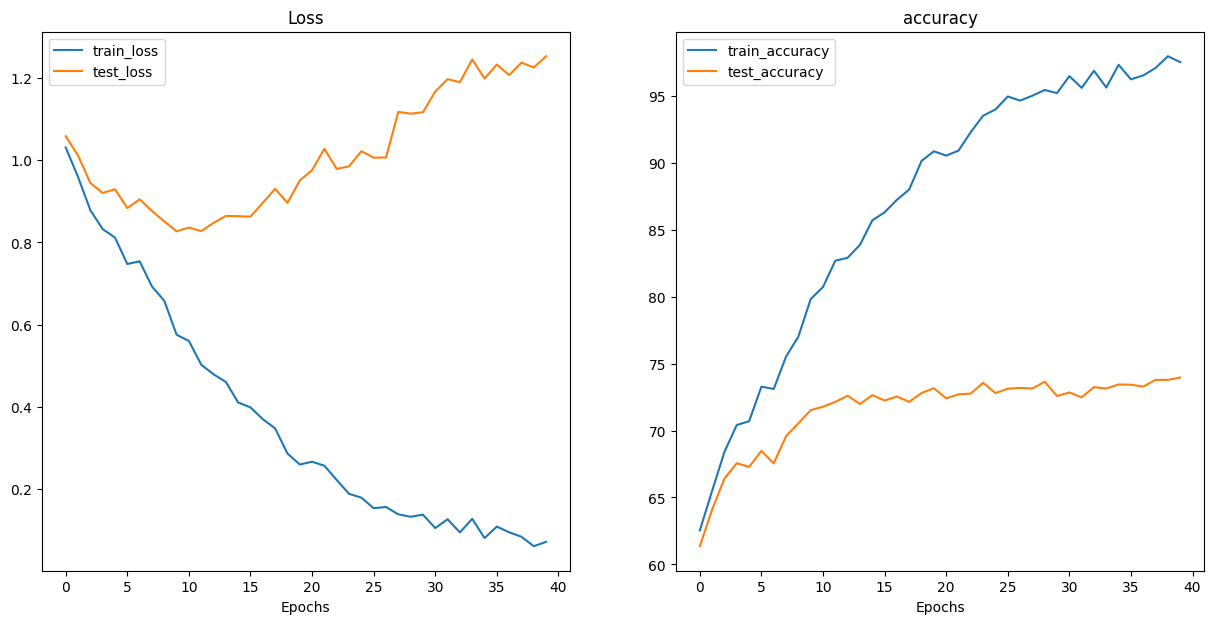

In [20]:
plot_loss_curves(log_dict)

Challenge:


Overfitting: This occurs when the model memorizes the training data too well and doesn't generalize well to unseen data. It can lead to a significant gap between training and validation loss curves.

Solutions:
Use techniques like dropout, regularization (e.g., L1/L2 weight decay), data augmentation, or early stopping to prevent overfitting.
Increase the complexity of your training dataset (e.g., by adding more diverse examples).